In [50]:
options = {
        'optim': {
            'lr': .001,
            'batch_size': 16,
            'epochs': 1
        }
    }
import torchvision.utils as tvu
import argparse
import click
import h5py
import json
import numpy as np
import os
import pickle
import random
import shutil
import yaml
from PIL import Image
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor, LongTensor
from torch.autograd import Variable
from tensorboard import SummaryWriter

import vqa.lib.engine as engine
import vqa.lib.utils as utils
import vqa.lib.logger as logger
import vqa.lib.criterions as criterions
import vqa.datasets as datasets
import vqa.models as models
from vqa.models.cx import RandomBaseline, DistanceBaseline, BlackBox, LinearContext
import vqa.models.seq2vec as s2v
from train import load_checkpoint
with open('options/vqa2/counterexamples_default.yaml', 'r') as handle:
        options_yaml = yaml.load(handle)
options = utils.update_values(options, options_yaml)
options['vgenome'] = None
import matplotlib.gridspec as gridspec
%matplotlib inline

In [19]:
trainset_fname = 'trainset_augmented.pickle'
valset_fname = 'valset_augmented.pickle'
trainset = pickle.load(open(os.path.join(options['vqa']['path_trainset'], trainset_fname), 'rb'))

print('=> Loading KNN data...')
knns = json.load(open(options['coco']['path_knn'], 'r'))
knns = {int(k):v for k,v in knns.items()}
print('=> Loading COCO image features...')
features_train = h5py.File(os.path.join(options['coco']['path_raw'], 'trainset.hdf5'), 'r').get('noatt')
features_train = np.array(features_train)

print('=> Building model...')

# cx_model = DistanceBaseline(knn_size=24)
vqa_model = models.factory(options['model'],
trainset['vocab_words'], trainset['vocab_answers'],
cuda=True, data_parallel=True)
vqa_model = vqa_model.module
cx_model = LinearContext(vqa_model, knn_size=24)
cx_model.cuda()


=> Loading KNN data...
=> Loading COCO image features...
=> Building model...


LinearContext(
  (vqa_model): MutanNoAtt(
    (seq2vec): BayesianUniSkip(
      (embedding): Embedding(12714, 620, padding_idx=0)
      (rnn): BayesianGRU(
        (gru_cell): BayesianGRUCell(
          (weight_ir): Linear(in_features=620, out_features=2400)
          (weight_ii): Linear(in_features=620, out_features=2400)
          (weight_in): Linear(in_features=620, out_features=2400)
          (weight_hr): Linear(in_features=2400, out_features=2400)
          (weight_hi): Linear(in_features=2400, out_features=2400)
          (weight_hn): Linear(in_features=2400, out_features=2400)
          (drop_ir): SequentialDropout(0.2500)
          (drop_ii): SequentialDropout(0.2500)
          (drop_in): SequentialDropout(0.2500)
          (drop_hr): SequentialDropout(0.2500)
          (drop_hi): SequentialDropout(0.2500)
          (drop_hn): SequentialDropout(0.2500)
        )
      )
    )
    (linear_classif): Linear(in_features=360, out_features=2000)
    (fusion): MutanFusion(
      (lin

In [35]:
w2id = {}
for i,w in enumerate(trainset['vocab_words']):
    w2id[w] = i
aid2wids = {}
good_answers = []
for i,a in enumerate(trainset['vocab_answers']):
    answer_words = a.split()
    aid2wids[i] = [w2id[aw] for aw in answer_words if aw in w2id]
    if all([aw in w2id for aw in answer_words]):
        good_answers.append(i)
    

In [21]:
s = set()
for i,a in enumerate(trainset['vocab_answers']):
    answer_words = a.split()
    for aw in answer_words:
        if aw not in w2id:
            s.add(aw)

In [23]:


def batchify(example_list, batch_size, shuffle=True):
    if shuffle:
        random.shuffle(example_list)
    batched_dataset = []
    for i in range(0, len(example_list), batch_size):
        batched_dataset.append(example_list[i:min(i + batch_size, len(example_list))])
    return batched_dataset


def getDataFromBatch(batch, features, name_to_index):
    image_idxs = []
    question_wids = []
    answer_aids = []
    comp_idxs = []

    for ex in batch:
        image_idx = [name_to_index[ex['image_name']]]
        knn_idxs = [name_to_index[name] for name in ex['knns']]
        image_idxs.append(image_idx + knn_idxs)
        question_wids.append(ex['question_wids'])
        answer_aids.append(ex['answer_aid'])
        comp_idxs.append(ex['comp']['knn_index'])

    image_features = torch.from_numpy(np.array([features[idxs] for idxs in image_idxs])).cuda()
    question_wids = torch.LongTensor(question_wids).cuda()
    answer_aids = torch.LongTensor(answer_aids).cuda()
    comp_idxs = Variable(torch.LongTensor(comp_idxs), requires_grad=False).cuda()

    return image_features, question_wids, answer_aids, comp_idxs


def recallAtK(scores, ground_truth, k=5):
    assert(scores.shape[0] == ground_truth.shape[0])
    _, top_idxs = scores.topk(k)
    ground_truth = ground_truth.cpu().data.numpy()
    return (Tensor(ground_truth.reshape((-1, 1))).expand_as(top_idxs).numpy() == \
            top_idxs.cpu().data.numpy()).sum(axis=1)


def coco_name_to_num(name):
    assert(name[-4:] == '.jpg')
    assert(name[-17] == '_')
    return int(name[-16:-4])


def coco_num_to_name(num, split='train'):
    if len(str(num)) > 12:
        raise ValueError
    if split == 'train':
        return 'COCO_train2014_{}.jpg'.format(str(num).zfill(12))
    elif split == 'val':
        return 'COCO_val2014_{}.jpg'.format(str(num).zfill(12))
    else:
        raise ValueError('split must be train or val; got {}'.format(split))

In [53]:
optimizer = torch.optim.Adam(cx_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter()

for epoch in range(0, options['optim']['epochs']):

    # TRAIN
    total_examples = total_correct = 0

    for batch in tqdm(batchify(trainset['examples_list'], batch_size=options['optim']['batch_size'])):
#         aembed = vqa_model.seq2vec(batch[0]['answer_wids'])
        if batch[0]['answer_aid'] in good_answers:
            print(batch[0]['answer'])
            wids = aid2wids[batch[0]['answer_aid']]
            print(vqa_model.seq2vec(Variable(torch.cuda.LongTensor([wids]))))
#         img_name = batch[0]['image_name']
#         knns = batch[0]['knns']
#         question = batch[0]['question']
#         answer = batch[0]['answer']
#         comp = batch[0]['comp']['image_name']
#         image_features, question_wids, answer_aids, comp_idxs = getDataFromBatch(batch, features_train, trainset['name_to_index'])
        break


                                                                                                                                                                                                                                                                                                                                                                                                               

   #TODO: Val


  0%|          | 0/13227 [00:00<?, ?it/s]

yes
Variable containing:
-4.4577e-02 -1.0416e-02 -7.8311e-02  ...   7.4781e-02  6.3842e-02 -1.0038e-01
[torch.cuda.FloatTensor of size 1x2400 (GPU 0)]



In [193]:
from torchvision.transforms import ToTensor, CenterCrop, Compose, Pad

In [36]:
img = Image(filename=os.path.join('data/coco/raw/train2014', knns[3]))

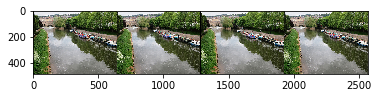

In [64]:
show(tvu.make_grid([img_tensor, img_tensor, img_tensor, img_tensor],nrow=4))

In [48]:
img = Image.open(os.path.join('data/coco/raw/train2014', img_name))

In [51]:
img_tensor = ToTensor()(img)

In [243]:
def viz_knns(img_name, knn_names, comp_name, question, answer, n_display):
    def show(img1, img2, size1, size2):
        fig = plt.figure(figsize=(20,10))
        fig.text(.5,.140, "Q: " + question + "\nA: " + answer, ha='center', fontsize=24)
        gridspec.GridSpec(1,4)
        plt.subplot2grid((1,4), (0,0))
        npimg = img1.numpy()
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
        
        
        plt.subplot2grid((1,4), (0,1), colspan=3, rowspan=1)
        npimg = img2.numpy()
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
#         plt.show()
        fig.tight_layout()
        plt.savefig('demo.jpg')
    names = knn_names[:n_display] if comp_name in knn_names else knn_names[:n_display-1] + [comp_name]
    comp_index = names.index(comp_name)
    imgs = [Image.open(os.path.join('data/coco/raw/train2014', name)) for name in names]
    img_tensors = []
    for i, img in enumerate(imgs):
        if i == comp_index:
            border_width = 10
            transform = Compose([    
                CenterCrop(360-2*border_width),
                Pad(border_width, (256,0,0)),        
                ToTensor(),
            ])
        else:
            transform = Compose([    
                CenterCrop(360),
                ToTensor(),
            ])
        
        img_tensors.append(transform(img))
    
    orig = transform(Image.open(os.path.join('data/coco/raw/train2014', img_name)))
    
    show(orig, tvu.make_grid(img_tensors), (5,5), (20,10))
    

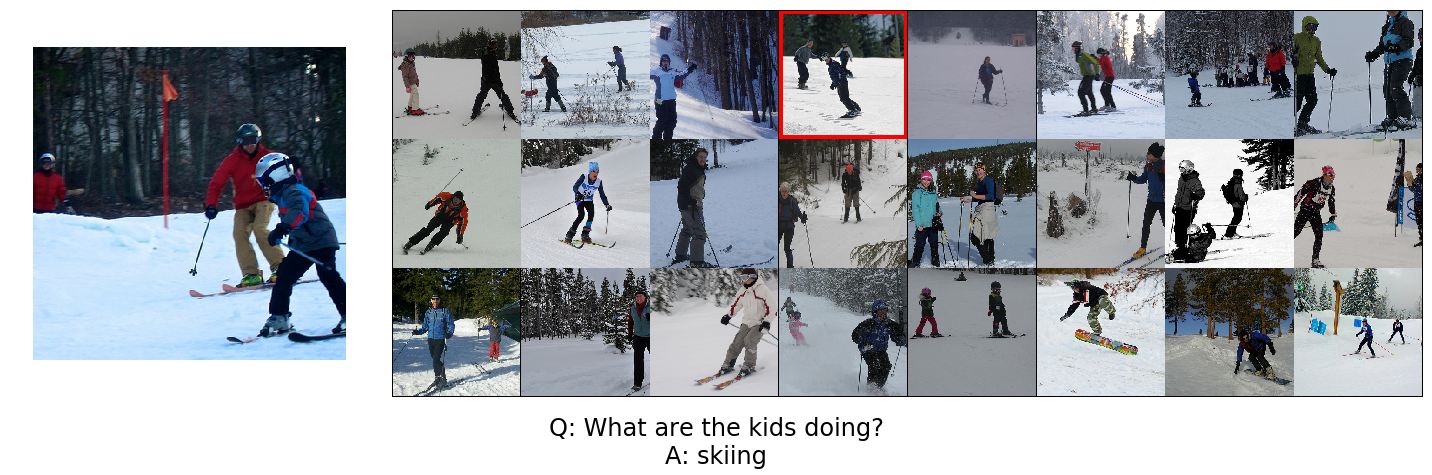

In [244]:
viz_knns(img_name, knns, comp, question, answer, 24)

In [4]:
type(trainset)

dict

In [24]:
el_filtered = [ex for ex in trainset['examples_list'] if ex['answer_aid'] in good_answers]

In [25]:
len(trainset['examples_list'])

211626

In [27]:
len(el_filtered) - len(trainset['examples_list'])

-842